# Homework Module 6

The goal of this homework is to create a regression model for predicting the car fuel efficiency (column 'fuel_efficiency_mpg').

### Preparing the dataset 

Preparation:

* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [1]:
#!pip install xgboost

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text
from sklearn.metrics import root_mean_squared_error

import xgboost as xgb


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv')
df.head(2)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors,fuel_efficiency_mpg
0,170,3.0,159.0,3413.433759,17.7,2003,Europe,Gasoline,All-wheel drive,0.0,13.231729
1,130,5.0,97.0,3149.664934,17.8,2007,USA,Gasoline,Front-wheel drive,0.0,13.688217


In [4]:
df.fillna(0, inplace=True)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [6]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [7]:
y_train = df_train.fuel_efficiency_mpg.values
y_val = df_val.fuel_efficiency_mpg.values
y_test = df_test.fuel_efficiency_mpg.values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [8]:
df_train.head(2)

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors
0,120,5.0,169.0,2966.679505,13.9,2005,USA,Gasoline,Front-wheel drive,-1.0
1,200,3.0,143.0,2950.822121,17.1,2013,Asia,Diesel,Front-wheel drive,-1.0


In [9]:
dv = DictVectorizer(sparse=True)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

## Question 1

Let's train a decision tree regressor to predict the `fuel_efficiency_mpg` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?


* `'vehicle_weight'`
* `'model_year'`
* `'origin'`
* `'fuel_type'`

In [10]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

,criterion,'squared_error'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,ccp_alpha,0.0


In [11]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))


|--- vehicle_weight <= 3022.11
|   |--- value: [16.88]
|--- vehicle_weight >  3022.11
|   |--- value: [12.94]



## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on the validation data?

* 0.045
* 0.45
* 4.5
* 45.0

In [12]:
regr = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
regr.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [13]:
y_pred = regr.predict(X_val)

In [14]:
round(root_mean_squared_error(y_val, y_pred), 3)

0.459

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

If it doesn't stop improving, use the latest iteration number in
your answer.

In [15]:
scores = []

for n in range(10, 201, 10):
    regr = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    regr.fit(X_train, y_train)

    y_pred = regr.predict(X_val)
    rmse = round(root_mean_squared_error(y_val, y_pred), 3)
    
    scores.append((n, rmse))

In [16]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])


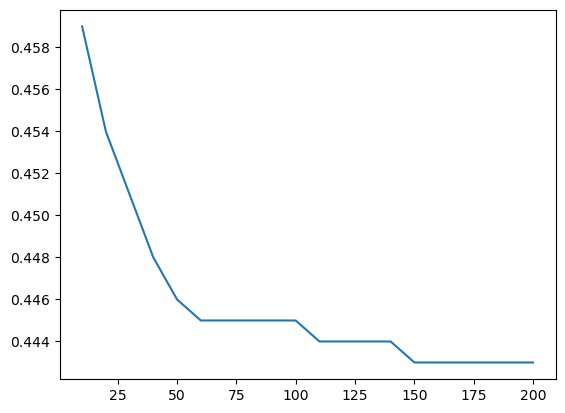

In [17]:
plt.plot(df_scores.n_estimators, df_scores.rmse)


## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [18]:
scores = []

for max_d in [10, 15, 20, 25]:
    rmses = []
    for n in range(10, 201, 10):
        regr = RandomForestRegressor(n_estimators=n, max_depth=max_d, random_state=1, n_jobs=-1)
        regr.fit(X_train, y_train)

        y_pred = regr.predict(X_val)
        rmse = round(root_mean_squared_error(y_val, y_pred), 3)
        rmses.append(rmse)
    rmse_mean = np.mean(rmses)
    scores.append((max_d, n, rmse_mean))

In [19]:
columns = ['max_depth', 'n_estimators', 'mean_rmse']
df_scores = pd.DataFrame(scores, columns=columns)

In [20]:
df_scores.sort_values(by='mean_rmse')

,max_depth,n_estimators,mean_rmse
0,10,200,0.4420
1,15,200,0.4456
2,20,200,0.4457
3,25,200,0.4458


# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `vehicle_weight`
*	`horsepower`
* `acceleration`
* `engine_displacement`	

In [21]:
regr = RandomForestRegressor(
    n_estimators=10,
    max_depth=20,
    random_state=1,
    n_jobs=-1
)

regr.fit(X_train, y_train)

,n_estimators,10
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
feature_names = df_train.columns
feature_importance = regr.feature_importances_

In [23]:
print(X_train.shape[1])
print(len(regr.feature_importances_))


14
14


In [24]:
feature_names = dv.get_feature_names_out()
importances = pd.Series(regr.feature_importances_, index=feature_names)
print(importances.sort_values(ascending=False).head(4))


vehicle_weight         0.959153
horsepower             0.016066
acceleration           0.011490
engine_displacement    0.003279
dtype: float64


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [25]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [26]:
watchlist = [(dtrain, 'train'), (dval, 'val')]


In [27]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)

[0]	train-rmse:1.81393	val-rmse:1.85444
[5]	train-rmse:0.51381	val-rmse:0.55664
[10]	train-rmse:0.37115	val-rmse:0.43896
[15]	train-rmse:0.34666	val-rmse:0.43362
[20]	train-rmse:0.33553	val-rmse:0.43376
[25]	train-rmse:0.32268	val-rmse:0.43683
[30]	train-rmse:0.31475	val-rmse:0.43752
[35]	train-rmse:0.30960	val-rmse:0.43784
[40]	train-rmse:0.30202	val-rmse:0.43968
[45]	train-rmse:0.29126	val-rmse:0.44024
[50]	train-rmse:0.28456	val-rmse:0.44140
[55]	train-rmse:0.27618	val-rmse:0.44225
[60]	train-rmse:0.26768	val-rmse:0.44290
[65]	train-rmse:0.26174	val-rmse:0.44352
[70]	train-rmse:0.25489	val-rmse:0.44531
[75]	train-rmse:0.24792	val-rmse:0.44628
[80]	train-rmse:0.24254	val-rmse:0.44689
[85]	train-rmse:0.23644	val-rmse:0.44749
[90]	train-rmse:0.23193	val-rmse:0.44839
[95]	train-rmse:0.22475	val-rmse:0.44904
[99]	train-rmse:0.21950	val-rmse:0.45018


In [28]:
y_pred = model.predict(dval)
rmse = root_mean_squared_error(y_val, y_pred)
rmse

0.45017755678087246

In [29]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                  verbose_eval=5,
                  evals=watchlist)


[0]	train-rmse:2.28944	val-rmse:2.34561
[5]	train-rmse:1.41247	val-rmse:1.44988
[10]	train-rmse:0.91008	val-rmse:0.94062
[15]	train-rmse:0.63402	val-rmse:0.66672
[20]	train-rmse:0.48983	val-rmse:0.53064
[25]	train-rmse:0.41881	val-rmse:0.46891
[30]	train-rmse:0.38342	val-rmse:0.44289
[35]	train-rmse:0.36435	val-rmse:0.43250
[40]	train-rmse:0.35343	val-rmse:0.42746
[45]	train-rmse:0.34621	val-rmse:0.42595
[50]	train-rmse:0.33998	val-rmse:0.42498
[55]	train-rmse:0.33480	val-rmse:0.42449
[60]	train-rmse:0.33054	val-rmse:0.42456
[65]	train-rmse:0.32602	val-rmse:0.42493
[70]	train-rmse:0.32202	val-rmse:0.42503
[75]	train-rmse:0.31895	val-rmse:0.42526
[80]	train-rmse:0.31667	val-rmse:0.42563
[85]	train-rmse:0.31440	val-rmse:0.42574
[90]	train-rmse:0.31059	val-rmse:0.42586
[95]	train-rmse:0.30625	val-rmse:0.42611
[99]	train-rmse:0.30419	val-rmse:0.42623


In [30]:
y_pred = model.predict(dval)
rmse = root_mean_squared_error(y_val, y_pred)
rmse

0.42622800553359225